<a id='Title-Feature-Extraction'></a>
<h1 style="color:SlateGray;">Feature Extraction</h1>

**Input dataset**

Kaggle Cats and Dogs: a set of evenly split cat and dog images.

**Output classification**

Predict whether an image contains a cat or a dog.

<h2 style="color:SlateGray;">Background</h2>

**Pre-trained models**

<a id='Pre-trained-models-VGG16'></a>
*VGG16*

A general purpose image classification model.

Implemented as a sequence of Conv2D and MaxPooling2D layers - this model was trained on the Image Net dataset for strong localization and image classification capabilities.

**Layers**

[*Dense*](01_Image_Classification.ipynb#Layers-Dense)

[*Dropout*](05_Overfitting_And_Underfitting.ipynb#Layers-Dropout)

**Activations**

[*relu*](01_Image_Classification.ipynb#Activations-relu)

[*sigmoid*](02_Binary_Classification.ipynb#Activations-sigmoid)
		
**Optimizers**

[*rmsprop*](01_Image_Classification.ipynb#Optimizers-rmsprop)
		
**Loss functions**

[*binary_crossentropy*](02_Binary_Classification.ipynb#Loss-functions-binary_crossentropy)

<h2 style="color:SlateGray;">Overview</h2>

Implementation of the feature extraction without data augmentation technique using a pre-trained convNet. As no training is done in the feature extraction step, this implementation is very computationally light and therefore fast.

Instantiates two separate models - a VGG16 model as a convolutional base and a simple Dense classifier. A data generator feeds in data from a structured directory to the convolutional base, which then outputs a tuple of extracted features and labels. That tuple is then used as input to the classifier producing the final prediction.


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [2]:
import os

base_dir = r'./cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                           target_size=(150, 150),
                                           batch_size=batch_size,
                                           class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break;
    return features, labels

In [5]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   verbose=2,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
 - 2s - loss: 0.5947 - acc: 0.6825 - val_loss: 0.4249 - val_acc: 0.8520
Epoch 2/30
 - 1s - loss: 0.4264 - acc: 0.8195 - val_loss: 0.3530 - val_acc: 0.8640
Epoch 3/30
 - 1s - loss: 0.3601 - acc: 0.8435 - val_loss: 0.3141 - val_acc: 0.8810
Epoch 4/30
 - 1s - loss: 0.3151 - acc: 0.8700 - val_loss: 0.2972 - val_acc: 0.8850
Epoch 5/30
 - 1s - loss: 0.2799 - acc: 0.8855 - val_loss: 0.2806 - val_acc: 0.8920
Epoch 6/30
 - 1s - loss: 0.2548 - acc: 0.8995 - val_loss: 0.2682 - val_acc: 0.8920
Epoch 7/30
 - 1s - loss: 0.2429 - acc: 0.9050 - val_loss: 0.2651 - val_acc: 0.8960
Epoch 8/30
 - 1s - loss: 0.2326 - acc: 0.9060 - val_loss: 0.2672 - val_acc: 0.8890
Epoch 9/30
 - 1s - loss: 0.2146 - acc: 0.9175 - val_loss: 0.2630 - val_acc: 0.8850
Epoch 10/30
 - 1s - loss: 0.2005 - acc: 0.9255 - val_loss: 0.2449 - val_acc: 0.9020
Epoch 11/30
 - 1s - loss: 0.1916 - acc: 0.9305 - val_loss: 0.2446 - val_acc: 0.9040
Epoch 12/30
 - 1s - loss: 0.1799 - ac

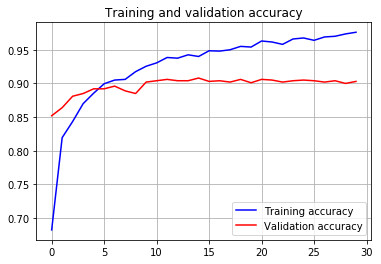

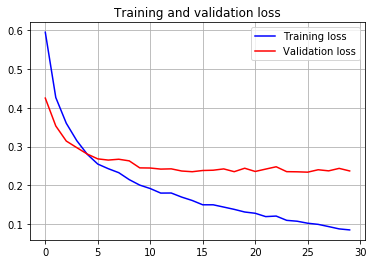

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()